In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import scipy as sp

In [2]:
import tensorflow as tf         
from tensorflow.keras.utils import to_categorical    
import tensorflow.keras.layers as tfl
from keras.datasets import cifar10
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [4]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape

(50000, 10)

In [5]:
def resize(img):
    numberofImage = img.shape[0]
    new_array = np.zeros((numberofImage,48,48,3))
    for i in range(numberofImage):
        new_array[i] = tf.image.resize(img[i],(48,48))
    return new_array


In [6]:
X_train = resize(X_train)

In [7]:
X_test = resize(X_test)

In [8]:
VGG16_model_base = tf.keras.applications.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [9]:
VGG16_model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [10]:
last = VGG16_model_base.get_layer('block3_pool').output

In [12]:
x = tf.keras.layers.GlobalAveragePooling2D()(last)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
pred = tf.keras.layers.Dense(10, activation='softmax')(x)
VGG16_model = tf.keras.Model(VGG16_model_base.input, pred)

In [13]:
for layer in VGG16_model_base.layers:
     layer.trainable = False

In [14]:
VGG16_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     y_train, 
                                     batch_size=32)

val_datagen = ImageDataGenerator(rescale=1. / 255,horizontal_flip=False)
val_datagen.fit(X_test)
val_generator = val_datagen.flow(X_test,
                                 y_test,
                                 batch_size=32)

In [17]:
train_steps_epoch = X_train.shape[0] // 32
val_steps_epoch = X_test.shape[0] // 32

hist = VGG16_model.fit(X_train,y_train,
                steps_per_epoch=train_steps_epoch,
                validation_data=(X_test,y_test),
                validation_steps=val_steps_epoch,epochs=10, verbose=1)

Epoch 1/10
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1994 - accuracy: 0.5849 - val_loss: 0.1610 - val_accuracy: 0.6681
Epoch 2/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1774 - accuracy: 0.6334
Epoch 3/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1653 - accuracy: 0.6623
Epoch 4/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1559 - accuracy: 0.6806
Epoch 5/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1507 - accuracy: 0.6934
Epoch 6/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1447 - accuracy: 0.7067
Epoch 7/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1411 - accuracy: 0.7109
Epoch 8/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1383 - accuracy: 0.7183
Epoch 9/10
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1358 - accuracy: 0.7246
Epoch 10/10
1562/1562 

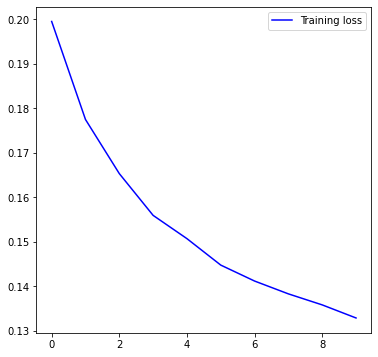

<Figure size 432x288 with 0 Axes>

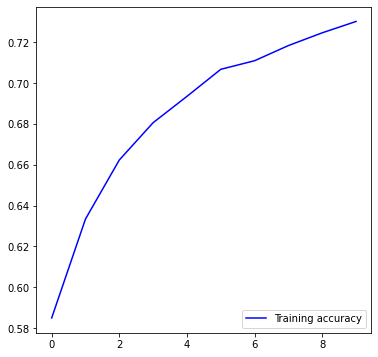

In [18]:
plt.figure(figsize=(6,6))
plt.plot(hist.history['loss'], color='b', label="Training loss")
#plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(6,6))
plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
#plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [20]:
predictions = VGG16_model.predict(X_test/255.)

In [21]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [24]:
evaluation = VGG16_model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

313/313 [==============================] - 5s 14ms/step - loss: 0.1209 - accuracy: 0.7485
Test Accuracy : 74.85%
